In [1]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr



In [2]:
##1. Open the ECCO grid
grid_dir  = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/')
## Open the temperature and salinity files between 1992-2019
ds_grid   = xr.open_dataset(grid_dir / 'GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))

In [4]:
##2. Calculate the monthly OHC from temperature
T      = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##This loops throughout the 336 monthly files 1992-2017
    ds        = xr.open_dataset(file_path)
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    temp      = ds.THETA
    T[month_idx].append(temp)
depth_names   = T[0][0].Z.values ## extract the depths from a random temperature file
##set some constants
rho       = 1025  # kg/m³
cp        = 3985   # J/(kg·°C)
deep      = 6;shallow = 0 ##choose indices of the lowest and upper depth of the water column to be examined
##construct the thickness of
upper     = ds_grid.Zu;bottom = ds_grid.Zl
dz        = bottom - upper;
dz_1d     = xr.DataArray([dz.isel(k_l=i, k_u=i).values for i in range(dz.sizes['k_l'])], dims=['k'])
dz_layer  = dz_1d.isel(k=slice(shallow, deep))  # select the dz values for the vertical slice

In [6]:
##2. Calculate the monthly OHC for a given tile in the SO
tile        = 0
OHC_monthly = [[] for _ in range(12)]  # Store one 3D field per month-year
for month in range(12):
    for temp in T[month]:  # each `temp` is one DataArray (tile, k, j, i)
        temp_layer        = temp[0].isel(k=slice(shallow, deep))  # select k=0 to 6
        dz_layer_reshaped = dz_layer.broadcast_like(temp_layer)
        ohc               = (temp_layer * dz_layer_reshaped).sum(dim="k")  # °C·m
        ohc               = ohc * rho * cp  # Convert to J/m²
        OHC_monthly[month].append(ohc)
# -- -- -- -- 2D Monthly OHC anomalies -- -- -- -- 
#a list of 12 xarray DataArrays, one per month, each with dimensions (year, tile, j, i)
OHC_monthly_stacked = [xr.concat(month_data, dim="year") for month_data in OHC_monthly]
#a list of 12 DataArrays, one per month, each with dimensions (tile, j, i)
OHC_climatology     = [monthly.mean(dim="year") for monthly in OHC_monthly_stacked]
OHC_anomalies       = [monthly - climatology for monthly, climatology in zip(OHC_monthly_stacked, OHC_climatology)]

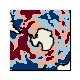

In [7]:
##3. Do an example of a monthly plot of OHC
nrow   = 4;ncol=7
cmin   = -8e7;cmax =8e7;years= np.arange(1992,2020,1)
colorm = cmocean.cm.balance
m      = 0;a=0
var    = OHC_anomalies[m][a,:,:,:]
cmin   =-8e7;cmax =8e7;years= np.arange(1992,2020,1)
colorm = cmocean.cm.balance
var    = OHC_anomalies[10][a,:,:,:] ##january/first year/have to mhednizo the xrono
ecco.plot_proj_to_latlon_grid(ds_grid.XC, ds_grid.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=False,dx=1, dy=1,lat_lim=-40,cmin=cmin,cmax=cmax,colormap=colorm,show_coastline=True,subplot_grid=[nrow, ncol, a+1]);


KeyboardInterrupt: 

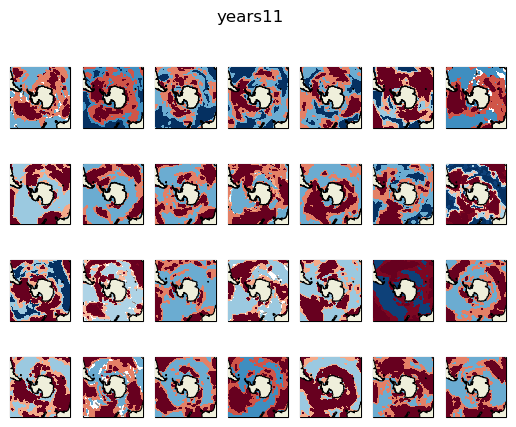

In [8]:
##4. Plot the OHC anomalies for each month 
montitles   = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
m           = 0
years       = np.arange(1992,2020,1)
nrow        = 4;ncol=7
cmin        = -8e7;cmax =8e7;years= np.arange(1992,2020,1)
colorm      = cmocean.cm.balance
for m in range(12):# loop over months
 for a in range(0,28): #loop over the years
     var = OHC_anomalies[m][a,:,:,:] ##january/first year/have to mhednizo the xrono
     fig = ecco.plot_proj_to_latlon_grid(ds_grid.XC, ds_grid.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=False,dx=1, dy=1,lat_lim=-40,cmin=cmin,cmax=cmax,colormap=colorm,show_coastline=True,subplot_grid=[nrow, ncol, a+1]);
     fig[0].suptitle(f'years{a}')
 #plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/OHC_ANOM_{montitles[m]}_lower{deep}_upper{shallow}.png')

